In [2]:
#############################################################################################################################################
#
# Stock future performance classification based on text
#
# Approach:
#
# Build on top of it a 1D convolutional neural network, ending in a softmax output over 3 even categories.
# Use word Glove word vectors for large English text corpus as inputs model
#
# Steps
# 1) After cleaning, we convert all text samples in the dataset into sequences of word indices.  In this case, a "word index" would simply be an integer ID for the word. 
# 2) We consider the top 350,000 most commonly occuring words in the dataset
# 3) We truncate the sequences to a maximum length of 25,000 words.
# 5) We [repare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.
# 6) Then, we load this embedding matrix into a Keras Embedding layer, set to be frozen (its weights, the embedding vectors, will not be updated during training).
#
###############################################################################################################################################

# import libraries
from __future__ import print_function
import numpy as np
from six.moves import zip
import json
import warnings
import pandas as pd
from pandas import DataFrame   
import pickle
import re
import sys 
import azureml
import string
from scipy import stats
import pip
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer     
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers.core import Dropout
from keras.layers import LSTM
from keras.layers import Dense, Input, Flatten 
from keras.layers import Conv1D, MaxPooling1D, Embedding 
from keras.models import Model 
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from keras.applications import imagenet_utils
from keras.layers import Embedding
from keras.utils.np_utils import to_categorical
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
import keras.backend as K
import os
import tempfile  
import logging
import gensim
from gensim.models import Phrases, phrases
from gensim.models.phrases import Phraser
from gensim.models import Word2Vec as wv
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models, similarities
from IPython.display import SVG
import cloudpickle
import csv
import mkl
import matplotlib.pyplot as plt
import h5py
from keras.models import load_model
import re
import io
from os.path import dirname, join
import regex
import graphviz
import pydotplus
import pyparsing
from keras.utils import plot_model




C:\Users\kero5\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\kero5\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [32]:

##########################################
# Get Previously Organized Stock Data
##########################################

HOME_DIR = 'C:/Users/kero5/Documents/UW/4B/ECE457B/Project'


labelled_data = pd.concat([
    pd.read_csv(HOME_DIR + '/Data/labelled_data0.csv'),
    pd.read_csv(HOME_DIR + '/Data/labelled_data1.csv'),
    pd.read_csv(HOME_DIR + '/Data/labelled_data2.csv')
])
print(labelled_data.shape)

#np.random.seed(1337)  # for reproducibility

#################################
#If necessary, convert categories
#################################
#thedata['ReturnQuantile'] = thedata['ReturnQuantile'].map({0:0,1:1,2:1,3:1,4:2})
print('Review the unique labels',labelled_date['label'].unique())

##########################################
# clean up the text in the data with regex
##########################################

def clean_text(row):
    # text = row['text'].encode('utf-8').lower()
    text = row['merged_text'].lower()

    # Remove newline characters
    cleantext = text.replace('\r\n', ' ')

    # Convert HTML punctuation chaaracters
    cleantext = cleantext.replace(' www.', ' ')   
    cleantext = cleantext.replace('.com ', ' ')    
    cleantext = cleantext.replace('.', ' ')
    cleantext = cleantext.replace(',', ' ')
    cleantext = cleantext.replace('!', ' ')
    cleantext = cleantext.replace('$;', ' ')
    cleantext = cleantext.replace(';', ' ')
    cleantext = cleantext.replace(')', ' ')
    cleantext = cleantext.replace('(', ' ')   
    cleantext = cleantext.replace('>', ' ')  
    cleantext = cleantext.replace('<', ' ')  
    cleantext = cleantext.replace('-', ' ')  #take away hyphen and collapse hyphenated words
    cleantext = cleantext.replace(' the ', ' ')  
    cleantext = cleantext.replace(' of ', ' ')   
    cleantext = cleantext.replace(' in ', ' ')  
    cleantext = cleantext.replace(' and ', ' ')  
    cleantext = cleantext.replace(' by ', ' ')  
    cleantext = cleantext.replace(' to ', ' ')  
    cleantext = cleantext.replace(' at ', ' ')  
    cleantext = cleantext.replace(' on ', ' ') 
    cleantext = cleantext.replace(' for ', ' ')  
    cleantext = cleantext.replace(' be ', ' ')   
    cleantext = cleantext.replace(' is ', ' ')    
    cleantext = cleantext.replace(' or ', ' ')   
    cleantext = cleantext.replace(' we ', ' ')   
    cleantext = cleantext.replace(' that ', ' ')   
    cleantext = cleantext.replace(' our ', ' ')   
    cleantext = cleantext.replace(' as ', ' ')        
    cleantext = cleantext.replace(' from ', ' ')   
    cleantext = cleantext.replace(' are ', ' ')   
    cleantext = cleantext.replace(' with ', ' ')   
    cleantext = cleantext.replace(' us ', ' ')   
    cleantext = cleantext.replace(' was ', ' ')        
    cleantext = cleantext.replace(' this ', ' ')   
    cleantext = cleantext.replace(' an ', ' ')        
    cleantext = cleantext.replace(' by ', ' ')   
    cleantext = cleantext.replace(' sr ', ' ')      
    cleantext = cleantext.replace(' it ', ' ')  
    cleantext = cleantext.replace(' s ', ' ')
    
    # added in ECE457B
    cleantext = cleantext.replace(' you ', ' ') 
    cleantext = cleantext.replace(' they ', ' ')   
    cleantext = cleantext.replace(' your ', ' ')   

    #remove non alpha characters and specific noise
    cleantext = re.sub(r'\d+', ' ',cleantext)
    cleantext = re.sub(r'^b',' ',cleantext)
    cleantext = re.sub(r'[^\w]',' ',cleantext)
    cleantext = cleantext.replace('xc xs', ' ')  
    cleantext = cleantext.replace('xe xs', ' ')  
    cleantext = cleantext.replace('xc xS', ' ')  
    cleantext = cleantext.replace('xe xS', ' ')  
    cleantext = cleantext.replace('xc xa', ' ')  
    cleantext = cleantext.replace('xe xa', ' ')  
    cleantext = cleantext.replace(' xc xc x', ' ')  
    cleantext = cleantext.replace(' xc ', ' ')  
    cleantext = cleantext.replace(' xe ', ' ')  
    cleantext = cleantext.replace(' xs ', ' ')  
    cleantext = cleantext.replace(' xa ', ' ')  
    cleantext = cleantext.replace(' ct ', ' ')  
    cleantext = cleantext.replace(' x ', ' ')  
    cleantext = cleantext.replace(' non exclusive ', ' non-exclusive ') 
    cleantext = cleantext.replace(' u ', ' ')   
    cleantext = cleantext.replace(' s ', ' ')  
    
    #remove specific noise
    cleantext = cleantext.translate(str.maketrans({'‘':' ','’':' '}))
    cleantext = cleantext.translate(str.maketrans({',':' ',',':' '}))
    cleantext = cleantext.translate(str.maketrans({'[':' ',']':' '}))
    cleantext = cleantext.translate(str.maketrans({'"':' ','%':' '}))
    cleantext = cleantext.translate(str.maketrans({'^':' ','*':' '}))

    #remove punctuation
    punctpattern = re.compile('[%s]' % re.escape(string.punctuation))
    cleanttext = re.sub(punctpattern,'', cleantext)

    #remove single letter word
    cleantext = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', cleantext) 

    # Remove extra spaces
    cleantext = re.sub('\s+', ' ', cleantext).strip()

    return cleantext

#apply regex fixes to the input text column
labelled_data['merged_text'] = labelled_data.apply(clean_text, axis=1)
labelled_data.to_csv(HOME_DIR + '//Data//cleaned.csv', sep='\t', encoding='utf-8')

print(labelled_data.shape)
labelled_data.head(2)

(1081, 6)
Review the unique labels ['neutral' 'negative' 'positive']
(1081, 6)


,date,sample_count,merged_text,weighted_daily_price,price_change_1d,label
0,2015-10-05,1374,where smart money placing their bets then when...,239.428434,-0.001299,neutral
1,2015-03-30,1578,the bitcoin tip bits has been collected youfig...,246.012185,-0.000229,neutral


In [33]:
print(labelled_data.shape)
labelled_data.sort_values(by=['date'])

(1081, 6)


,date,sample_count,merged_text,weighted_daily_price,price_change_1d,label
186,2015-01-14,3709,here information usaggybagz history has usaggy...,169.483398,-0.348141,negative
78,2015-01-15,3434,what qualifications looked through profile doe...,187.067433,0.103751,positive
172,2015-01-16,2124,no oz silver medallion gold accents bearing bi...,195.910316,0.047271,positive
314,2015-01-17,1673,unocoinsnothappy cap wants send bitcoin tip bi...,208.618659,0.064868,positive
133,2015-01-20,2337,the bitcoin tip hug bits has been collected pe...,221.658632,0.037223,positive
62,2015-01-21,2234,fast access bitcoins case want make occasional...,223.797728,0.009650,neutral
127,2015-01-22,2236,people using bitcoin changetip etcexclusively ...,233.379664,0.042815,positive
316,2015-01-23,1984,just described bitcoin merchants brah what exa...,229.873546,-0.015023,negative
320,2015-01-24,1580,good morning fellow bitcoin traders est januar...,245.171916,0.066551,positive
99,2015-01-25,1906,its very design bitcoin makes political statem...,249.245839,0.016617,neutral


In [34]:
################################
# Convert labels to categorical
################################
justcleandocs = labelled_data['merged_text']
print('post regex justcleandocs\n',justcleandocs.head(10))

justlabels=pd.DataFrame(labelled_data['label'])
print('head of just labels\n',justlabels.head(5))

###################################################
# Set Global Vars
####################################################
MAX_SEQUENCE_LENGTH = 10000
MAX_NB_WORDS = 400000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
LEARNING_RATE = .00011
BATCH_SIZE = 32
DROPOUT_RATE = 0.45
INNERLAYER_DROPOUT_RATE = 0.15
np.random.seed(2032)

#change directory to write results
GLOVE_DIR = HOME_DIR + '/glove/'


post regex justcleandocs
 0    where smart money placing their bets then when...
1    the bitcoin tip bits has been collected youfig...
2    funny how interview viabtc about need bigger b...
3    i bot bleep bloop someone has linked thread an...
4    just spent half year kenya have say pesa every...
5    fidelity mining bitcoins collaborates coinbase...
6    the ones subscribe currently let talk bitcoin ...
7    probably just copying layout evo because many ...
8    hey there cheyenne sweet petite kinky camshows...
9    guess will see end year bitcoin died like time...
Name: merged_text, dtype: object
head of just labels
       label
0   neutral
1   neutral
2  negative
3   neutral
4   neutral


In [35]:

######################################################
# Format our text samples and labels for use in Keras
######################################################
# Then we can format our text samples and labels into tensors that can be fed into a neural network. 
# Here we tokenize our source 'justcleandocs'
# note that the values here are ultimately indexes to the actual words

#convert text format
justcleandocslist  = justcleandocs.values
justcleandocslist[6]

# convert labels to int
label_id_mapping = {'negative':0, 'neutral':1, 'positive':2}
labels  = justlabels.replace({'label': label_id_mapping}).values

labels_index = {}
labels_index =  {0:0,1:1,2:2}
print('labels_index', labels_index)

#tokenize the text
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(justcleandocslist) #tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(justcleandocslist) #sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index #word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))
#print('sequences first', sequences[0])

#Pad sequences so that they all have the same length in a batch of input data 
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre')
sequences = None
texts = None


##################################################
#build label array from target y label in data set
##################################################
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
X_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('length of y_val',len(y_val))
print('shape of y_val',y_val.shape)
print('length of X_val',len(X_val))
print('shape of X_val',X_val.shape)

#os.chdir('C:\\glove\\nextagenda')

#from itertools import islice
#head = list(islice(y_val, 6))
#print('head of yval',head)

#####################################
# Save Validation Set for Evaluation
####################################
np.savetxt('y_val_3bin.txt', y_val, delimiter=',')
np.savetxt('X_val_3bin.txt', X_val,  fmt='%s', delimiter=',')
print('test and training sets saved to disk for later evaluation')

labels_index {0: 0, 1: 1, 2: 2}
Found 949794 unique tokens
Shape of data tensor:  (1081, 10000)
Shape of label tensor:  (1081, 3)
length of y_val 216
shape of y_val (216, 3)
length of X_val 216
shape of X_val (216, 10000)
test and training sets saved to disk for later evaluation


In [36]:

########################################
# Preparing the embedding layer
########################################

#load in word vectors from glove reference global English data set
# https://nlp.stanford.edu/projects/glove/
# see more reference links at bottom

print('Loading word vectors to prepare the embedding layer...')
print(os.getcwd())

embeddings_index = {}
print('Loading Glove Model...')
gloveFile = GLOVE_DIR + '/glove.6B.300d.txt'
words = pd.read_table(gloveFile, sep=" ", header=None, quoting=csv.QUOTE_NONE)

print(words.head(5))
print('shape of glove model',words.shape)

wordkeys=words.iloc[:,0]
print('wordkeys type of file', type(wordkeys))
words2 = words.rename(columns={ words.columns[0]: "words" })
words2['words'].apply(str)
#print(words2.dtypes)

embeddings_index = words2.set_index('words').T.to_dict('list')

#print(dict(list(embeddings_index.items())[0:2]))
print('Found {} word vectors.'.format(len(embeddings_index)))
#usage of pandas function dataFrame.to_dict(outtype='dict') outtype : str {‘dict’, ‘list’, ‘series’}


#################################
#Build the embedding matrix
#################################

print('Building Embedding Matrix...')
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


Loading word vectors to prepare the embedding layer...
C:\Users\kero5\Documents\UW\4B\ECE457B\Project\JupyterNotebooks
Loading Glove Model...
   0         1         2         3         4         5         6         7    \
0  the  0.046560  0.213180 -0.007436 -0.458540 -0.035639  0.236430 -0.288360   
1    , -0.255390 -0.257230  0.131690 -0.042688  0.218170 -0.022702 -0.178540   
2    . -0.125590  0.013630  0.103060 -0.101230  0.098128  0.136270 -0.107210   
3   of -0.076947 -0.021211  0.212710 -0.722320 -0.139880 -0.122340 -0.175210   
4   to -0.257560 -0.057132 -0.671900 -0.380820 -0.364210 -0.082155 -0.010955   

        8         9      ...          291       292       293       294  \
0  0.215210 -0.134860    ...    -0.013064 -0.296860 -0.079913  0.195000   
1  0.107560  0.058936    ...     0.075968 -0.014359 -0.073794  0.221760   
2  0.236970  0.328700    ...     0.060148 -0.156190 -0.119490  0.234450   
3  0.121370 -0.070866    ...    -0.366730 -0.386030  0.302900  0.015747   
4 

C:\Users\kero5\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: DataFrame columns are not unique, some columns will be omitted.


Found 399998 word vectors.
Building Embedding Matrix...


In [37]:

##############################################
#Training a 1D convnet
##############################################

print('Train 1D Convnet with global maxpooling')
print('Shape of training data sample tensor: ', X_train.shape)
print('Shape of training label tensor: ', y_train.shape)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')


embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(INNERLAYER_DROPOUT_RATE)(x)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(INNERLAYER_DROPOUT_RATE)(x)

x = Conv1D(128, 5, activation='elu', kernel_initializer='lecun_uniform')(x)
x = MaxPooling1D(35)(x)  # global max pooling

x = Flatten()(x)
x = Dense(100, activation='elu', kernel_initializer='lecun_uniform')(x) # best initializers: #glorot_normal #VarianceScaling #lecun_uniform
x = Dropout(DROPOUT_RATE)(x)

preds = Dense(len(labels_index), activation='softmax')(x) #no initialization in output layer


model = Model(sequence_input, preds)


Train 1D Convnet with global maxpooling
Shape of training data sample tensor:  (865, 10000)
Shape of training label tensor:  (865, 3)


Train on 865 samples, validate on 216 samples
Epoch 1/10
865/865 [==============================] - 287s 332ms/step - loss: 1.0198 - acc: 0.5480 - val_loss: 1.0318 - val_acc: 0.5324
Epoch 2/10
865/865 [==============================] - 295s 341ms/step - loss: 1.0008 - acc: 0.5676 - val_loss: 1.0312 - val_acc: 0.5324
Epoch 3/10
865/865 [==============================] - 255s 295ms/step - loss: 0.9802 - acc: 0.5746 - val_loss: 1.0319 - val_acc: 0.5324
Epoch 4/10
865/865 [==============================] - 265s 307ms/step - loss: 0.9831 - acc: 0.5734 - val_loss: 1.0112 - val_acc: 0.5324
Epoch 5/10
865/865 [==============================] - 286s 331ms/step - loss: 0.9852 - acc: 0.5688 - val_loss: 1.0116 - val_acc: 0.5324
Epoch 6/10
865/865 [==============================] - 246s 285ms/step - loss: 0.9761 - acc: 0.5850 - val_loss: 1.0284 - val_acc: 0.5324
Epoch 7/10
865/865 [==============================] - 256s 296ms/step - loss: 0.9866 - acc: 0.5688 - val_loss: 1.0105 - val_acc: 0.5324
Ep

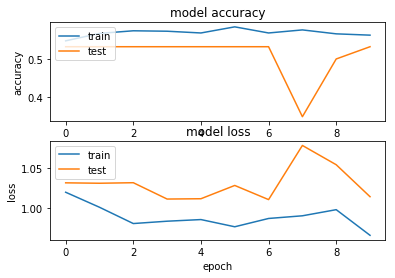

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [39]:
################################
#Compile model, set optimizers
################################

MAX_SEQUENCE_LENGTH = 10000
MAX_NB_WORDS = 400000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
LEARNING_RATE = .00011
BATCH_SIZE = 36
DROPOUT_RATE = 0.45
INNERLAYER_DROPOUT_RATE = 0.15


adam = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipvalue=0.5)#, clipnorm=1.)
rmsprop = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=1e-08, decay=0.00)

model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])
from keras.callbacks import History 
history = History()

early_stopping = EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=10,
          validation_data=(X_val, y_val), callbacks=[early_stopping, history])


##############################
# Save Model and Plots
##############################
model.save(GLOVE_DIR+'tockText_3Level3EvenClass_modelNov2_8pm.h5')
 
import matplotlib.pyplot as plt  
plt.figure(1)  

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

plot_model(model, to_file=GLOVE_DIR+'\stocktext_model3class.png')

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

##############################
# More helpful links
##############################

#We can also test how well we would have performed by not using pre-trained word embeddings, 
#but instead initializing our Embedding layer from scratch and learning its weights during training. 

#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
#https://arxiv.org/abs/1603.03827 
#https://nlp.stanford.edu/projects/glove/ 
#https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
#https://stackoverflow.com/questions/27139908/load-precomputed-vectors-gensim?rq=1
#https://stackoverflow.com/questions/14415741/numpy-array-vs-asarray

In [ ]:
Train on 283 samples, validate on 70 samples
Epoch 1/24
283/283 [==============================] - 87s 309ms/step - loss: 1.3329 - acc: 0.4664 - val_loss: 1.0088 - val_acc: 0.5571
Epoch 2/24
283/283 [==============================] - 85s 302ms/step - loss: 1.1907 - acc: 0.3781 - val_loss: 1.0115 - val_acc: 0.5571
Epoch 3/24
283/283 [==============================] - 81s 287ms/step - loss: 1.1227 - acc: 0.5265 - val_loss: 0.9900 - val_acc: 0.5571
Epoch 4/24
283/283 [==============================] - 79s 281ms/step - loss: 1.0947 - acc: 0.4417 - val_loss: 0.9886 - val_acc: 0.5571
Epoch 5/24
283/283 [==============================] - 77s 273ms/step - loss: 1.0927 - acc: 0.5018 - val_loss: 1.0153 - val_acc: 0.5571
Epoch 6/24
283/283 [==============================] - 77s 273ms/step - loss: 1.0709 - acc: 0.4735 - val_loss: 0.9918 - val_acc: 0.5571
Epoch 7/24
283/283 [==============================] - 80s 282ms/step - loss: 1.0672 - acc: 0.4806 - val_loss: 1.0154 - val_acc: 0.5571
Epoch 8/24
283/283 [==============================] - 80s 283ms/step - loss: 1.0179 - acc: 0.5265 - val_loss: 0.9844 - val_acc: 0.5571
Epoch 9/24
283/283 [==============================] - 80s 282ms/step - loss: 1.0337 - acc: 0.5194 - val_loss: 0.9978 - val_acc: 0.5571
Epoch 10/24
283/283 [==============================] - 78s 274ms/step - loss: 1.0491 - acc: 0.5230 - val_loss: 1.0129 - val_acc: 0.5571
Epoch 11/24
283/283 [==============================] - 84s 297ms/step - loss: 0.9958 - acc: 0.5159 - val_loss: 1.0044 - val_acc: 0.5571
Epoch 12/24
283/283 [==============================] - 91s 323ms/step - loss: 1.0032 - acc: 0.5300 - val_loss: 1.0214 - val_acc: 0.5571
Epoch 13/24
283/283 [==============================] - 80s 284ms/step - loss: 0.9750 - acc: 0.5406 - val_loss: 0.9861 - val_acc: 0.5571
Epoch 14/24
283/283 [==============================] - 86s 304ms/step - loss: 1.0104 - acc: 0.5124 - val_loss: 1.0156 - val_acc: 0.5571
Epoch 15/24
283/283 [==============================] - 97s 341ms/step - loss: 1.0091 - acc: 0.5371 - val_loss: 1.0117 - val_acc: 0.5571
Epoch 16/24
283/283 [==============================] - 93s 328ms/step - loss: 1.0359 - acc: 0.4346 - val_loss: 0.9911 - val_acc: 0.5571
Epoch 17/24
283/283 [==============================] - 87s 307ms/step - loss: 1.0218 - acc: 0.5371 - val_loss: 1.0388 - val_acc: 0.5429
Epoch 18/24
128/283 [============>.................] - ETA: 41s - loss: 0.9980 - acc: 0.5312

In [ ]:
Train on 865 samples, validate on 216 samples
Epoch 1/10
865/865 [==============================] - 287s 332ms/step - loss: 1.0198 - acc: 0.5480 - val_loss: 1.0318 - val_acc: 0.5324
Epoch 2/10
865/865 [==============================] - 295s 341ms/step - loss: 1.0008 - acc: 0.5676 - val_loss: 1.0312 - val_acc: 0.5324
Epoch 3/10
865/865 [==============================] - 255s 295ms/step - loss: 0.9802 - acc: 0.5746 - val_loss: 1.0319 - val_acc: 0.5324
Epoch 4/10
865/865 [==============================] - 265s 307ms/step - loss: 0.9831 - acc: 0.5734 - val_loss: 1.0112 - val_acc: 0.5324
Epoch 5/10
865/865 [==============================] - 286s 331ms/step - loss: 0.9852 - acc: 0.5688 - val_loss: 1.0116 - val_acc: 0.5324
Epoch 6/10
865/865 [==============================] - 246s 285ms/step - loss: 0.9761 - acc: 0.5850 - val_loss: 1.0284 - val_acc: 0.5324
Epoch 7/10
865/865 [==============================] - 256s 296ms/step - loss: 0.9866 - acc: 0.5688 - val_loss: 1.0105 - val_acc: 0.5324
Epoch 8/10
865/865 [==============================] - 266s 308ms/step - loss: 0.9900 - acc: 0.5769 - val_loss: 1.0791 - val_acc: 0.3472
Epoch 9/10
865/865 [==============================] - 272s 315ms/step - loss: 0.9977 - acc: 0.5665 - val_loss: 1.0547 - val_acc: 0.5000
Epoch 10/10
865/865 [==============================] - 290s 335ms/step - loss: 0.9653 - acc: 0.5630 - val_loss: 1.0142 - val_acc: 0.5324